In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import threading
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, RationalQuadratic
from sklearn.preprocessing import StandardScaler
import time

# Data Processing

In [8]:
Data = pd.read_csv('SCNP_dataset.csv')
Data

,Comp,BID,SID,CID,rg,asph,acyl,anis,num dom,seg,...,eig2,eig3,eig4,eig5,eig6,eig7,eig8,eig9,eig10,n_eig
0,0.1,0.2,0,0,12.228701,61.184513,30.778156,0.212441,2,48,...,0.001016,0.001885,0.004115,0.004368,0.007120,0.008917,0.010192,0.010418,0.012773,0.000021
1,0.1,0.2,0,1,10.906473,45.301393,22.153887,0.183696,1,25,...,0.001981,0.002270,0.003840,0.004823,0.006086,0.007630,0.008078,0.008877,0.012746,0.000039
2,0.1,0.2,0,2,11.597649,51.393123,27.237148,0.188593,2,36,...,0.001227,0.001769,0.003387,0.004120,0.005110,0.005742,0.007127,0.008390,0.012078,0.000030
3,0.1,0.2,0,3,16.041229,155.108298,63.086271,0.407451,4,105,...,0.000499,0.002372,0.003987,0.005094,0.005925,0.007164,0.009113,0.011217,0.012627,0.000008
4,0.1,0.2,0,4,15.312193,139.605066,62.681879,0.410806,6,108,...,0.000487,0.002857,0.003377,0.005003,0.006256,0.006961,0.009035,0.012391,0.014306,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.8,0.8,39,19,7.353935,17.969779,10.097279,0.143275,1,4,...,0.005110,0.012039,0.013861,0.024233,0.024647,0.028329,0.041535,0.043056,0.048735,0.000017
7676,0.8,0.8,39,20,7.110865,18.012399,10.576299,0.166412,1,4,...,0.007475,0.012283,0.014657,0.019058,0.027062,0.029793,0.038675,0.041851,0.047963,0.000016
7677,0.8,0.8,39,21,7.068580,12.873496,6.076033,0.082558,1,4,...,0.004853,0.009125,0.019311,0.021287,0.026657,0.030698,0.034977,0.036610,0.048004,0.000028
7678,0.8,0.8,39,22,7.411105,21.967894,12.709280,0.208238,1,4,...,0.005929,0.011884,0.012992,0.019262,0.021154,0.028907,0.034192,0.040488,0.044181,0.000021


In [9]:
#Extract input data
Input = Data[['Comp', 'BID', 'SID']].drop_duplicates()
with open("SCNP_sequences.txt", "r", encoding="utf-8") as file:
    Sequence = file.readlines()  # Each line becomes a list element
Input['Sequence'] = Sequence
Input

,Comp,BID,SID,Sequence
0,0.1,0.2,0,0000000000000000000001000000000000010001000000...
24,0.1,0.2,1,0011100000000000000000001100000100100010000000...
48,0.1,0.2,2,0000000000000001000000001010000000110000000000...
72,0.1,0.2,3,0001000000000000000000000000010000010000001000...
96,0.1,0.2,4,0000000000000000000000000000000000000000000001...
...,...,...,...,...
7560,0.8,0.8,35,1111111111111111111111111111111111111111111111...
7584,0.8,0.8,36,0001111111111111111111111110011111111111111111...
7608,0.8,0.8,37,1111111111111100000001111111011111111111111111...
7632,0.8,0.8,38,0000001111111111111100000111111111100011111111...


In [10]:
Data = Data.merge(Input, on=['Comp', 'BID', 'SID'], how = 'left')
Data

,Comp,BID,SID,CID,rg,asph,acyl,anis,num dom,seg,...,eig3,eig4,eig5,eig6,eig7,eig8,eig9,eig10,n_eig,Sequence
0,0.1,0.2,0,0,12.228701,61.184513,30.778156,0.212441,2,48,...,0.001885,0.004115,0.004368,0.007120,0.008917,0.010192,0.010418,0.012773,0.000021,0000000000000000000001000000000000010001000000...
1,0.1,0.2,0,1,10.906473,45.301393,22.153887,0.183696,1,25,...,0.002270,0.003840,0.004823,0.006086,0.007630,0.008078,0.008877,0.012746,0.000039,0000000000000000000001000000000000010001000000...
2,0.1,0.2,0,2,11.597649,51.393123,27.237148,0.188593,2,36,...,0.001769,0.003387,0.004120,0.005110,0.005742,0.007127,0.008390,0.012078,0.000030,0000000000000000000001000000000000010001000000...
3,0.1,0.2,0,3,16.041229,155.108298,63.086271,0.407451,4,105,...,0.002372,0.003987,0.005094,0.005925,0.007164,0.009113,0.011217,0.012627,0.000008,0000000000000000000001000000000000010001000000...
4,0.1,0.2,0,4,15.312193,139.605066,62.681879,0.410806,6,108,...,0.002857,0.003377,0.005003,0.006256,0.006961,0.009035,0.012391,0.014306,0.000008,0000000000000000000001000000000000010001000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.8,0.8,39,19,7.353935,17.969779,10.097279,0.143275,1,4,...,0.012039,0.013861,0.024233,0.024647,0.028329,0.041535,0.043056,0.048735,0.000017,0000111111111111100001111111110000001111111111...
7676,0.8,0.8,39,20,7.110865,18.012399,10.576299,0.166412,1,4,...,0.012283,0.014657,0.019058,0.027062,0.029793,0.038675,0.041851,0.047963,0.000016,0000111111111111100001111111110000001111111111...
7677,0.8,0.8,39,21,7.068580,12.873496,6.076033,0.082558,1,4,...,0.009125,0.019311,0.021287,0.026657,0.030698,0.034977,0.036610,0.048004,0.000028,0000111111111111100001111111110000001111111111...
7678,0.8,0.8,39,22,7.411105,21.967894,12.709280,0.208238,1,4,...,0.011884,0.012992,0.019262,0.021154,0.028907,0.034192,0.040488,0.044181,0.000021,0000111111111111100001111111110000001111111111...


# Principal Component Analysis (PCA)

We take advantage of PCA as the dimensionality technique to simplify the sequencing. PCA projects data into a new coordinate system where the firts few coordinates (principal components) capture the most variance in data. The basica goal of PCA is to transform the original features into a smaller set of uncorrelated features while retaining as much information (variance) as possible.

The PCA process is as follows:

1/ **Standardize the Data:** Scale the data for PCA. The data is *mean-centered* (subtract the mean of each feature) and *scaled* (divided by the standard deviation) so that each feature has zero mean and unit variance.

2/ **Compute the Covariance Matrix:** The covariance matrix measures how much the features vary with respect to each other. It helps us understand the relationships between different features.

3/ **Eigenvalue Decomposition:** The covariance matrix is decomposed into eigenvectors and eigenvalues. The eigenvectors represent the principal components (directions of maximum variance), and the eigenvalues show how much variance each principal component accounts for.

4/ **Sort Eigenvalues and Eigenvectors:** Sort the eigenvectors based on the eigenvalues, from largest to smallest. The larger the eigenvalue, the more variance that principal component accounts for.

5/ **Projection onto New Axes:** The data is projected onto the eigenvectors (principal components). This results in a new set of features (principal components) that are linear combinations of the original features. The first principal component captures the largest variance, the second one captures the second largest, and so on.

6/ **Dimensionality Reduction:** By selecting the top *k* eigenvectors (those with the largest eigenvalues), we reduce the dataset’s dimensions. You can control how much variance is retained by adjusting k (the number of principal components you choose).


***We use a 70/15/15 split for the Train/Validate/Test sets***

Train: 224 sequences, 5376 total samples
Validation: 48 sequences, 1152 total samples
Test: 48 sequences, 1152 total samples

Explained variance ratio per PCA component:
PCA_0: 0.2303
PCA_1: 0.0135
PCA_2: 0.0127
PCA_3: 0.0120
PCA_4: 0.0116
PCA_5: 0.0114
PCA_6: 0.0111
PCA_7: 0.0106
PCA_8: 0.0105
PCA_9: 0.0101
PCA_10: 0.0100
PCA_11: 0.0099
PCA_12: 0.0097
PCA_13: 0.0095
PCA_14: 0.0093
PCA_15: 0.0092
PCA_16: 0.0090
PCA_17: 0.0089
PCA_18: 0.0087
PCA_19: 0.0086
PCA_20: 0.0085
PCA_21: 0.0084
PCA_22: 0.0083
PCA_23: 0.0082
PCA_24: 0.0080
PCA_25: 0.0079
PCA_26: 0.0078
PCA_27: 0.0076
PCA_28: 0.0076
PCA_29: 0.0075
PCA_30: 0.0074
PCA_31: 0.0073
PCA_32: 0.0072
PCA_33: 0.0071
PCA_34: 0.0070
PCA_35: 0.0069
PCA_36: 0.0069
PCA_37: 0.0068
PCA_38: 0.0067
PCA_39: 0.0066
PCA_40: 0.0064
PCA_41: 0.0063
PCA_42: 0.0063
PCA_43: 0.0061
PCA_44: 0.0061
PCA_45: 0.0059
PCA_46: 0.0059
PCA_47: 0.0058
PCA_48: 0.0058
PCA_49: 0.0057

Cumulative explained variance:
Up to PCA_0: 0.2303
Up to PCA_1: 0.2438
Up to PCA_2: 0.256

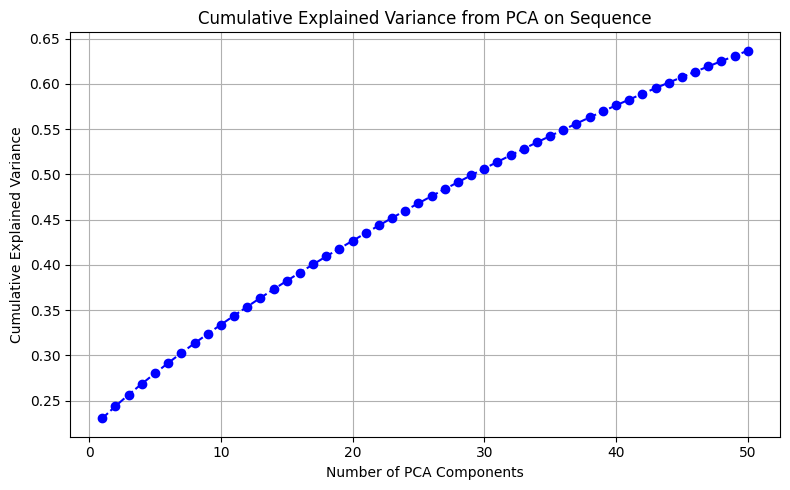

In [11]:
unique_sequences = Data["Sequence"].unique()
# Ensure a proper 70/15/15 split (Train/Validation/Test)
train_seq, temp_seq = train_test_split(unique_sequences, test_size=0.3, random_state=42)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.5, random_state=42)  # Split remaining 30% into 15%/15%

# Assign each row to the corresponding split based on its Sequence
df_train = Data[Data["Sequence"].isin(train_seq)].copy()
df_val = Data[Data["Sequence"].isin(val_seq)].copy()
df_test = Data[Data["Sequence"].isin(test_seq)].copy()

# Convert Sequence column (binary string) to numerical array
def sequence_to_array(seq):
    seq = str(seq).strip()  # Remove spaces/newlines
    seq = ''.join(filter(lambda x: x in '01', seq))  # Keep only '0' and '1'
    return list(map(int, list(seq)))  # Convert to list of integers

df_train["Sequence"] = df_train["Sequence"].apply(sequence_to_array)
df_val["Sequence"] = df_val["Sequence"].apply(sequence_to_array)
df_test["Sequence"] = df_test["Sequence"].apply(sequence_to_array)

# Ensure all sequences have the same length
seq_length = len(df_train["Sequence"].iloc[0])
assert all(len(seq) == seq_length for seq in df_train["Sequence"]), "Sequence length mismatch!"

# Convert sequences to NumPy arrays
X_seq_train = np.vstack(df_train["Sequence"].values)
X_seq_val = np.vstack(df_val["Sequence"].values)
X_seq_test = np.vstack(df_test["Sequence"].values)

# Apply PCA (reduce to 50 principal components)
pca = PCA(n_components=50)
X_seq_train_pca = pca.fit_transform(X_seq_train)
X_seq_val_pca = pca.transform(X_seq_val)
X_seq_test_pca = pca.transform(X_seq_test)

# Add PCA-transformed sequences back to DataFrame
for i in range(50):
    df_train[f"PCA_{i}"] = X_seq_train_pca[:, i]
    df_val[f"PCA_{i}"] = X_seq_val_pca[:, i]
    df_test[f"PCA_{i}"] = X_seq_test_pca[:, i]

# Drop original Sequence column (no longer needed)
df_train = df_train.drop(columns=["Sequence"])
df_val = df_val.drop(columns=["Sequence"])
df_test = df_test.drop(columns=["Sequence"])

# Save preprocessed data
df_train.to_csv("train_data_pca.csv", index=False)
df_val.to_csv("val_data_pca.csv", index=False)
df_test.to_csv("test_data_pca.csv", index=False)

# Print results
print(f"Train: {len(train_seq)} sequences, {df_train.shape[0]} total samples")
print(f"Validation: {len(val_seq)} sequences, {df_val.shape[0]} total samples")
print(f"Test: {len(test_seq)} sequences, {df_test.shape[0]} total samples")
# ----------------------------------------------
# Examine explained variance from PCA
# ----------------------------------------------
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print explained variance for each component
print("\nExplained variance ratio per PCA component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PCA_{i}: {var:.4f}")

print("\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"Up to PCA_{i}: {cum_var:.4f}")

# Optionally, plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, 51), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title("Cumulative Explained Variance from PCA on Sequence")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


## Gaussian Process Regression (GPR)

GPR is a non-parametric method for regression tasks. It's based on the **Gaussian Process** (GP), which are collections of random variables, any finite number of which have a joint Gaussian distribution. GPR provides a distribution over possible functions that fit the data and can predict both the mean and the uncertainty (variance) of the predictions.

1/ **Prior Distributions:** In GPR, we define a prior distribution over functions. A Gaussian process is specified by a **mean function** (often assumed to be zero) and a **covariance function** (kernel) that defines the correlation between pairs of data points.

2/ **Kernel Function:** The kernel defines the covariamce between two points. A commonly used kernel is te **Radial Basis Function (RBF)**, also known as the **Gaussian kernel**, which measures similarity between points based on their distance. It controls how "smooth" the function is.
$$k(x,x') = exp(-\frac{|x-x'|^2}{2\sigma^2}))$$ 
where $\sigma$ is a length parameter.

3/ **Likelihood Function:** The likelihood describes how the observed data relates to the underlying function. Typically, a Gaussian noise model is assumed, meaning that the data is generated from the underlying coupled with some normally distributed noise.

4/ **Posterior Distribution:** After observing the data, we update our prior belief (distribution over functions) to a **posterior** distribution. The posterior is also a Gaussian process, and it is conditioned on the observed data points.

5/ **Predictions:** GPR not only predicts the mean of the function at new points, but also provides the uncertainty (variance) of the prediction.

Separate Kernels for each properties

Radius of Gyration

In [12]:
# ---------- Select features ----------
pca_columns = [f"PCA_{i}" for i in range(50)]  # Use 50 PCA components
feature_cols = ['Comp', 'BID'] + pca_columns

X_train = df_train[feature_cols]
X_val = df_val[feature_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Select target ----------
target_variable = "rg"
y_train = df_train[target_variable].values
y_val = df_val[target_variable].values

# ---------- Kernel ----------
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

# ---------- Train GPR ----------
print(f"Training GPR for {target_variable}...")
start_time = time.time()

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
gpr.fit(X_train_scaled, y_train)

# ---------- Predict ----------
y_pred_val, y_pred_std_val = gpr.predict(X_val_scaled, return_std=True)

# ---------- Evaluate ----------
mse = mean_squared_error(y_val, y_pred_val)
print(f"\n Finished training for '{target_variable}'")
print(f"Validation MSE: {mse:.6f}")
print(f"Prediction shape: {y_pred_val.shape}")
print(f"Elapsed time: {(time.time() - start_time)/60:.2f} minutes")

# ---------- Save predictions ----------
results_df = df_val[["Comp", "BID"]].copy()
results_df[f"{target_variable}_true"] = y_val
results_df[f"{target_variable}_pred"] = y_pred_val
results_df[f"{target_variable}_std"] = y_pred_std_val

results_df.to_csv(f"gpr_results_{target_variable}.csv", index=False)
print(f"Saved predictions to gpr_results_{target_variable}.csv")

Training GPR for rg...

 Finished training for 'rg'
Validation MSE: 8.620650
Prediction shape: (1152,)
Elapsed time: 13.01 minutes
Saved predictions to gpr_results_rg.csv


In [13]:
# ---------- Select features ----------
pca_columns = [f"PCA_{i}" for i in range(50)]  # Use 50 PCA components
feature_cols = ['Comp', 'BID'] + pca_columns

X_train = df_train[feature_cols]
X_val = df_val[feature_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Select target ----------
target_variable = "anis"
y_train = df_train[target_variable].values
y_val = df_val[target_variable].values

# ---------- Kernel ----------
kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-4, 1e3))

# ---------- Train GPR ----------
print(f"Training GPR for {target_variable}...")
start_time = time.time()

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
gpr.fit(X_train_scaled, y_train)

# ---------- Predict ----------
y_pred_val, y_pred_std_val = gpr.predict(X_val_scaled, return_std=True)

# ---------- Evaluate ----------
mse = mean_squared_error(y_val, y_pred_val)
print(f"\n Finished training for '{target_variable}'")
print(f"Validation MSE: {mse:.6f}")
print(f"Prediction shape: {y_pred_val.shape}")
print(f"Elapsed time: {(time.time() - start_time)/60:.2f} minutes")

# ---------- Save predictions ----------
results_df = df_val[["Comp", "BID"]].copy()
results_df[f"{target_variable}_true"] = y_val
results_df[f"{target_variable}_pred"] = y_pred_val
results_df[f"{target_variable}_std"] = y_pred_std_val

results_df.to_csv(f"gpr_results_{target_variable}.csv", index=False)
print(f"Saved predictions to gpr_results_{target_variable}.csv")

Training GPR for anis...

 Finished training for 'anis'
Validation MSE: 0.015177
Prediction shape: (1152,)
Elapsed time: 23.71 minutes
Saved predictions to gpr_results_anis.csv


In [14]:
# ---------- Select features ----------
pca_columns = [f"PCA_{i}" for i in range(50)]  # Use 50 PCA components
feature_cols = ['Comp', 'BID'] + pca_columns

X_train = df_train[feature_cols]
X_val = df_val[feature_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Select target ----------
target_variable = "asph"
y_train = df_train[target_variable].values
y_val = df_val[target_variable].values

# ---------- Kernel ----------
kernel = C(1.0, (1e-3, 1e3)) * (RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
                                     RationalQuadratic(length_scale=1.0, alpha=0.1)) + \
              WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e1))

# ---------- Train GPR ----------
print(f"Training GPR for {target_variable}...")
start_time = time.time()

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
gpr.fit(X_train_scaled, y_train)

# ---------- Predict ----------
y_pred_val, y_pred_std_val = gpr.predict(X_val_scaled, return_std=True)

# ---------- Evaluate ----------
mse = mean_squared_error(y_val, y_pred_val)
print(f"\n Finished training for '{target_variable}'")
print(f"Validation MSE: {mse:.6f}")
print(f"Prediction shape: {y_pred_val.shape}")
print(f"Elapsed time: {(time.time() - start_time)/60:.2f} minutes")

# ---------- Save predictions ----------
results_df = df_val[["Comp", "BID"]].copy()
results_df[f"{target_variable}_true"] = y_val
results_df[f"{target_variable}_pred"] = y_pred_val
results_df[f"{target_variable}_std"] = y_pred_std_val

results_df.to_csv(f"gpr_results_{target_variable}.csv", index=False)
print(f"Saved predictions to gpr_results_{target_variable}.csv")

Training GPR for asph...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



 Finished training for 'asph'
Validation MSE: 2309.379204
Prediction shape: (1152,)
Elapsed time: 12.31 minutes
Saved predictions to gpr_results_asph.csv


In [15]:
# ---------- Select features ----------
pca_columns = [f"PCA_{i}" for i in range(50)]  # Use 50 PCA components
feature_cols = ['Comp', 'BID'] + pca_columns

X_train = df_train[feature_cols]
X_val = df_val[feature_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Select target ----------
target_variable = "acyl"
y_train = df_train[target_variable].values
y_val = df_val[target_variable].values

# ---------- Kernel ----------
kernel = C(1.0, (1e-3, 1e3)) * (RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
                                     RationalQuadratic(length_scale=1.0, alpha=0.1)) + \
              WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e1))

# ---------- Train GPR ----------
print(f"Training GPR for {target_variable}...")
start_time = time.time()

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
gpr.fit(X_train_scaled, y_train)

# ---------- Predict ----------
y_pred_val, y_pred_std_val = gpr.predict(X_val_scaled, return_std=True)

# ---------- Evaluate ----------
mse = mean_squared_error(y_val, y_pred_val)
print(f"\n Finished training for '{target_variable}'")
print(f"Validation MSE: {mse:.6f}")
print(f"Prediction shape: {y_pred_val.shape}")
print(f"Elapsed time: {(time.time() - start_time)/60:.2f} minutes")

# ---------- Save predictions ----------
results_df = df_val[["Comp", "BID"]].copy()
results_df[f"{target_variable}_true"] = y_val
results_df[f"{target_variable}_pred"] = y_pred_val
results_df[f"{target_variable}_std"] = y_pred_std_val

results_df.to_csv(f"gpr_results_{target_variable}.csv", index=False)
print(f"Saved predictions to gpr_results_{target_variable}.csv")

Training GPR for acyl...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



 Finished training for 'acyl'
Validation MSE: 334.360982
Prediction shape: (1152,)
Elapsed time: 39.28 minutes
Saved predictions to gpr_results_acyl.csv
